In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import scipy
from matplotlib import gridspec

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachman/anacon

In [28]:
from tensorflow.keras.layers import Layer

initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._c = self.add_weight(name='x', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), #initializer, #'uniform',
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return 1 - self._c * x

In [51]:
#Quick vanilla GAN from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
C=0

# define the standalone discriminator model
def define_discriminator(n_inputs=1):
	model = Sequential()
	model.add(Dense(25, activation='relu', input_dim=n_inputs))
	model.add(Dense(25, activation='relu', input_dim=n_inputs))    
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(n_outputs=1,myc=2.):
	#model = Sequential()
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))    
	#model.add(Dense(n_outputs, activation='linear'))

	mymodel_inputtest = Input(shape=(1,))
	mymodel_test = MyLayer(myc)(mymodel_inputtest)
	model = Model(mymodel_inputtest, mymodel_test)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	C = generator.layers[-1].get_weights()[0][0]
	print("Initial slope: ",C)
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	X = np.random.normal(0.5,1,n)
	y = ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(n):
	# generate points in the latent space
	x_input = generate_real_samples(n)
	return x_input[0]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input,batch_size=10000)
	# create class labels
	y = zeros((n, 1))
	return X, y

def generate_fake_samples_with_input(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input,batch_size=10000)
	# create class labels
	y = zeros((n, 1))
	return X, y, x_input
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.hist(x_real, color='red',alpha=0.5)
	pyplot.hist(x_fake, color='blue',alpha=0.5)
	pyplot.show()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, n_epochs=100000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model)
 
# size of the latent space
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(myc=1.)

# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model)

Initial slope:  1.0


In [52]:
xx = generate_fake_samples(generator, 100000)
yy = generate_real_samples(100000)

(array([   68.,   176.,   561.,  1272.,  2735.,  5052.,  7831., 11220.,
        13563., 14819., 13669., 11156.,  7955.,  4896.,  2760.,  1349.,
          585.,   219.,    63.]),
 array([-3.        , -2.63157895, -2.26315789, -1.89473684, -1.52631579,
        -1.15789474, -0.78947368, -0.42105263, -0.05263158,  0.31578947,
         0.68421053,  1.05263158,  1.42105263,  1.78947368,  2.15789474,
         2.52631579,  2.89473684,  3.26315789,  3.63157895,  4.        ]),
 <a list of 19 Patch objects>)

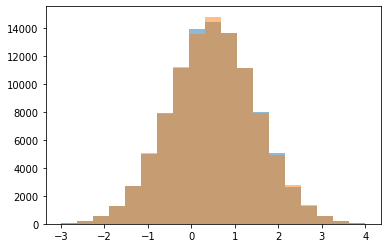

In [53]:
plt.hist(xx[0],bins=np.linspace(-3,4,20),alpha=0.5)
plt.hist(yy[0],bins=np.linspace(-3,4,20),alpha=0.5)

In [57]:
myfunction = generator.predict(np.linspace(-3,3,100))

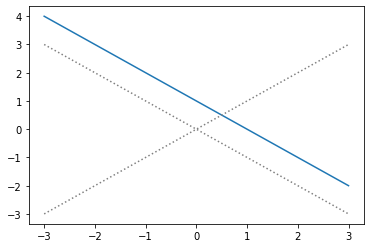

In [63]:
plt.plot(np.linspace(-3,3,100),myfunction)
plt.plot(np.linspace(-3,3,100),np.linspace(-3,3,100),ls=":",color="gray")
plt.plot(np.linspace(-3,3,100),np.linspace(3,-3,100),ls=":",color="gray")

In [56]:
print("final slope: ", generator.layers[-1].get_weights()[0][0])

final slope:  1.0


In [ ]:
#myvals = []
#for i in range(20):
#    print("on i=",i)
#    discriminator2 = define_discriminator()
#    generator2 = define_generator()
#    gan_model2 = define_gan(generator2, discriminator2)
#    train(generator2, discriminator2, gan_model2,n_eval=1000000000000000)
#    print("Final slope:", generator.layers[-1].get_weights()[0][0])
#    myvals +=[generator.layers[-1].get_weights()[0][0]]

In [ ]:
#plt.hist(myvals)
#plt.xlabel("slope", generator2.layers[-1].get_weights()[0][0]))

In [ ]:
losses = []

yy = generate_real_samples(100000)
for slope in np.linspace(-2,2,20):

    discriminator = define_discriminator()
    generator = define_generator(myc=slope)
    
    x_real, y_real = generate_real_samples(1000)
    x_fake, y_fake = generate_fake_samples(generator, 1000)

    discriminator.train_on_batch(x_real, y_real)
    discriminator.train_on_batch(x_fake, y_fake)
    
    gan_model = define_gan(generator, discriminator)
    
    myloss = gan_model.evaluate(x_fake, y_fake,batch_size=10000)
    
    losses += [myloss]

Initial slope:  -2.0
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -1.7894737
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -1.5789474
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -1.3684211
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -1.1578947
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -0.94736844
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -0.7368421
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -0.5263158
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  -0.31578946
1000/1000 [==============================] - 6s 6ms/step
Initial slope:  -0.10526316
1000/1000 [==============================] - 5s 5ms/step
Initial slope:  0.10526316
1000/1000 [==============================] - 6s 6ms/step
Initial slope:  0.31578946
1000/1000 [==============================] - 6s 6ms/

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

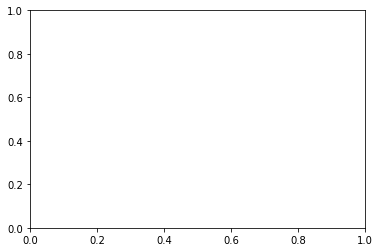

In [77]:
plt.plot(np.linspace(-2,2,20),losses)